# Image compression via URV (SVD/PCA) factorization
This notebook shows an application of the URV factorization in the field of image compression. We implement step by step the SVD and we use it to approximate the image and so the compress it. We will show how fixing different tolerances, we will select different number of components and how the compression quality improves. Then, we will show how to use the PCA as image compression tool and we will compare different strategy used to select the principal directions like tolerance and entropy.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.linalg as spl
import time
from sklearn.decomposition import PCA

In [2]:
img=mpimg.imread('0002.jpg')
rgb_weights = [0.2989, 0.5870, 0.1140] # define the RGB weights to convert in gray scale
imgg=np.dot(img,rgb_weights) # convert the image in a gray scale

Original image size:  (768, 1024, 3)
Gray image size:  (768, 1024)


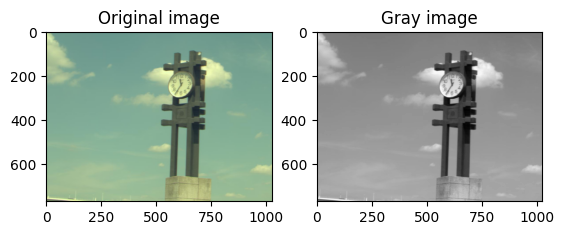

In [3]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(imgg, cmap = plt.cm.gray)
plt.title('Gray image')

print('Original image size: ', img.shape)
print('Gray image size: ', imgg.shape)

## Correlation index definition
We use the correlation index to check the quality of the approximation of the image. If the index is close to 1, we know that we obtain a good compression. If the index is close to 0, we know that the compression is not good. We have seen the correlation index between vectors, but in this case we have matrix. Firstly, we vectorize the matrix putting each column in one single column. To do this, we use the function <b>flat</b>.

In [4]:
def correlation_index(A,B):
    rhoxy=np.inner((A.flat - np.mean(A.flat)) / np.std(A.flat), (B.flat - np.mean(B.flat)) / np.std(B.flat))
    rhoxy = rhoxy/np.prod(A.shape)
    return rhoxy

## URV algorithm for image compression
To perform the qr factorization, we use the scipy routine qr of the modulus linalg with pivoting true to have the elements of the rectangular matrix ordered:
  
   $[Qimg,Rimg,Pimg]=spl.qr(imgg,pivoting=True)$

Note that Pimg contains the index of the permuted columns of imgg and the algorithm finds an orthogonal matrix Qimg and a rectangular matrix Rimg such that $imgg[:,Pimg]=Qimg*Rimg$.

Print the norm of the residual $imgg[:,Pimg]-Qimg*Rimg$

Compute the URV factorization by performing first the Q R factorization with pivoting and after the QR factorization on the resulting matrix Rimg transposed ($Rimg^T= V B$). The factorized matrix $A P = Q B^T V^T$. 


In [5]:
t1=time.process_time()

# We compute the QR on the matrix A, and we obtain A = Q*R 
# Pimg is a vector with the index of the permuted matrix
[Qimg,Rimg,Pimg]=spl.qr(imgg,pivoting=True) 
t2=time.process_time()
t1e=t2-t1

# Now we apply again the QR not on the matrix A.T but on the matrix T.T (See theory)
[Ql,Rl]=spl.qr(Rimg.T)
t2e=time.process_time()-t2

print(f'Time required to perform AP = QR: {t1e}\n'
      f'Time required up to the QR on the matrix R.T: {t2e}')
print('||imgg[:,Pimg] - Qimg*Rimg || / ||imgg|| =', np.linalg.norm(imgg[:,Pimg]-np.dot(Qimg,Rimg))/np.linalg.norm(imgg))
print('||imgg[:,Pimg] - (Qimg* Rl.T) * Ql.T|| / ||imgg|| =',
      np.linalg.norm(imgg[:,Pimg]-np.dot(np.dot(Qimg,Rl.T),Ql.T))/np.linalg.norm(imgg)) #UBV factorization
print('Since the residuals are small the computed factorization is good.')

Time required to perform AP = QR: 0.625
Time required up to the QR on the matrix R.T: 0.65625
||imgg[:,Pimg] - Qimg*Rimg || / ||imgg|| = 2.9005158488994704e-15
||imgg[:,Pimg] - (Qimg* Rl.T) * Ql.T|| / ||imgg|| = 2.9734486105043835e-15
Since the residuals are small the computed factorization is good.


Given the tolerances 1e-1,5e-2,1e-2,5e-3 compute an approximation of the matrix imgg by choosing only nc  columns of the matrix Qimg and nc rows and columns of the matrix B, and nc column of the matrix V where nc is chosen 
by computing: 

  1) extract the diagonal elements of B and copy in Bdiag
    
  2) scale the absolute values of Bdiag with respect to its absolute maximum
    
  3) compute nc as the number of elements of Bdiag that are greater of the chosen tolerance
    
Plot the approximate images in a gray scale and comment the results, comparing them with the same image obtained with the QR factorization. To compare the images, compute the correlation between the reconstructed image and the original one by writing the two images as two vectors. 

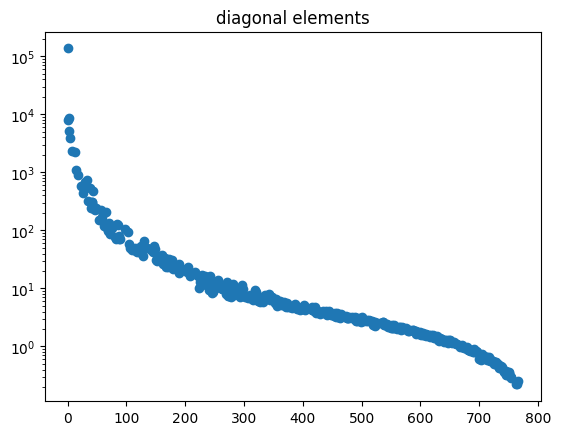

In [6]:
ndi=(np.diag(Rl)) # retrieve the diagonal elements and plot the diagonal elements
plt.semilogy(ndi,'o')
plt.title('diagonal elements')
plt.show()

Tolerance= 0.1, NComp= 1, Correlation index= 0.4111365541839361
Tolerance= 0.05, NComp= 3, Correlation index= 0.7308765484742835
Tolerance= 0.01, NComp= 15, Correlation index= 0.9182451990189681
Tolerance= 0.005, NComp= 24, Correlation index= 0.9796070205440558
Tolerance= 0.001, NComp= 67, Correlation index= 0.9983706780629471
Tolerance= 1e-05, NComp= 630, Correlation index= 0.9999996794940436
Tolerance= 1e-08, NComp= 768, Correlation index= 0.9999999999999885


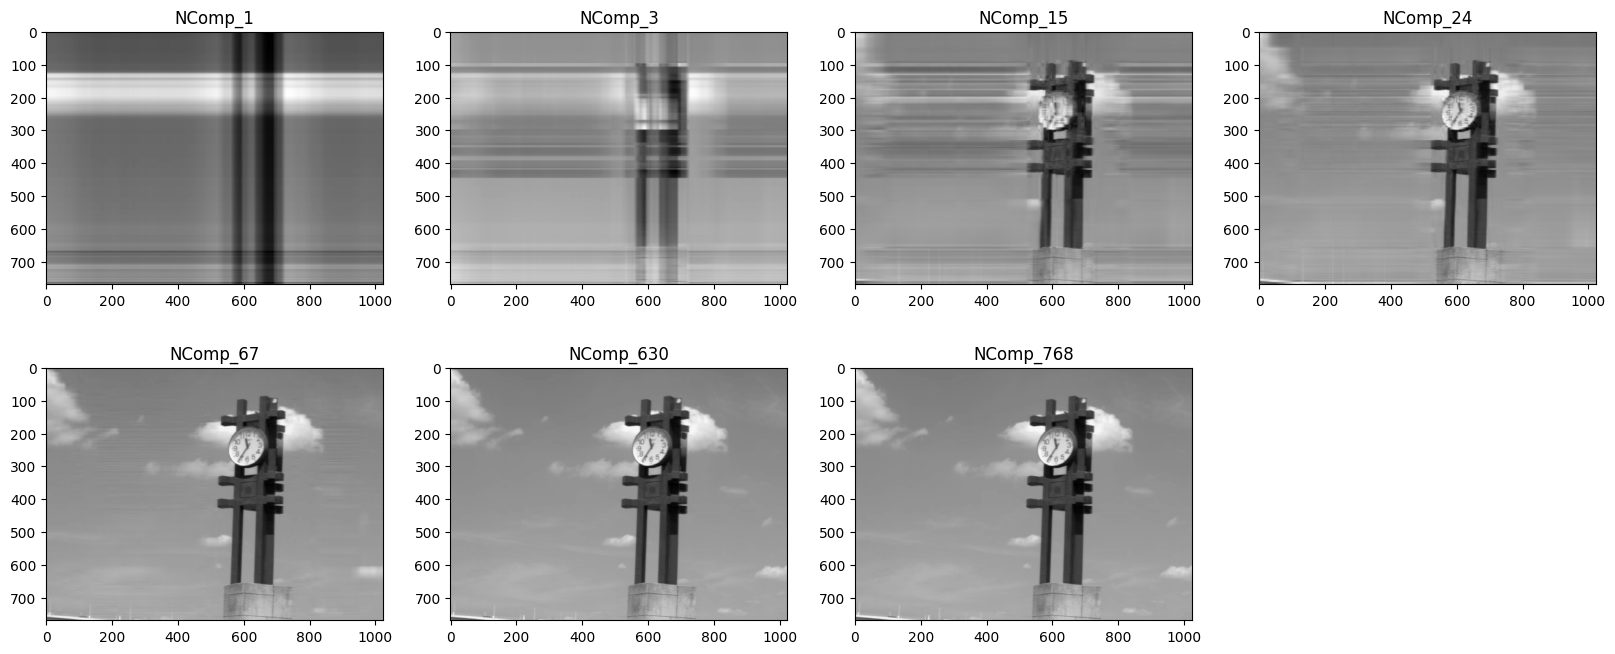

In [7]:
tol=[1e-1,5e-2,1e-2,5e-3,1e-3,1e-5,1e-8]
i = 0
plt.figure(figsize=(20,8))

for ind in tol:
 # Firstly, we scale the absolute value of each element
 # on the main diagonal dividing by the absolute value of 
 # the biggest element on the main diagonal; then we count
 # the number of diagonal elements greater than each threshold
 nc=np.sum(abs(ndi)/max(abs(ndi)) >= ind)

 # QA basis for the column space of A, we take only
 # the first nc columns of QA
 QA=np.copy(Qimg[:,0:nc]) 
 
 # Here we are taking the matrix B (obtained computing the 
 # QR on T transpose), and we compute the transposition
 RA=np.copy(Rl[0:nc,0:nc].T) 
 
 # Here we are taking the matrix Q (obtained computing the 
 # QR on T transpose), and we compute the transposition
 QLA=np.copy(Ql[:,0:nc].T)

 # Here we compute the dot product to restore the image
 # using only nc vectors
 Apimg=np.dot(np.dot(QA,RA),QLA)
 
 # Reconstruct the permutation matrix and we
 # perform the permutation 
 PTimg = np.zeros(Pimg.shape,dtype=int)
 PTimg[Pimg]=range(Pimg.shape[0])
 Apimg=Apimg[:,PTimg]
 
 # Compute the correlation index between
 # the original matrix and the approximated matrix
 rhoxy=correlation_index(imgg,Apimg)
 
 print(f'Tolerance= {tol[i]}, NComp= {nc}, Correlation index= {rhoxy}')
 plt.subplot(2, 4, i+1)
 plt.imshow(Apimg, cmap = plt.cm.gray)
 plt.title('NComp_' + str(nc))
 i = i+1

## SVD algorithm for image compression
Compute the singular value decomposition of the image and compute the rank nc approximation with a norm-2 error matrix less than the tolerances used in the previous experiments. Compare the results with the QR and the URV factorization using the correlation index. 
<b>NB</b>: the spl.svd output releated to the V matrix is already transposed. So we can just compute $A=U \Sigma V^T$ without transpose it again.

In [8]:
# we use full_matrices=False because we only need 
# the element of the range of the matrix. So, we take 
# only r columns of U and V.
Uimg, simg, Vimg = spl.svd(imgg, full_matrices=False)

print('- max value of imgg: ', np.max(np.max(abs(imgg))))
print(f'- max value of Vimg.T*Vimg: { np.max(np.abs(np.dot(Vimg.T,Vimg)))}'
      '\n (Matrix is orthogonal so we should obtain 1.\n'
      ' Since the matrix is very big, we never achieved 1) ')
print('\n- max sigma value: ', np.max(simg))
print(f'- comparing the 2-norm of imgg: {np.linalg.norm(imgg,2)} with the first singular value: {simg[0]}')
print('- residuals ||imgg - Uimg*simg*Vimg||/sigma1: ',np.linalg.norm(imgg-np.dot(Uimg*simg,Vimg),2)/simg[0])

- max value of imgg:  248.3347
- max value of Vimg.T*Vimg: 0.9966868405523218
 (Matrix is orthogonal so we should obtain 1.
 Since the matrix is very big, we never achieved 1) 

- max sigma value:  138012.958866858
- comparing the 2-norm of imgg: 138012.95886685804 with the first singular value: 138012.958866858
- residuals ||imgg - Uimg*simg*Vimg||/sigma1:  4.356413144300453e-15


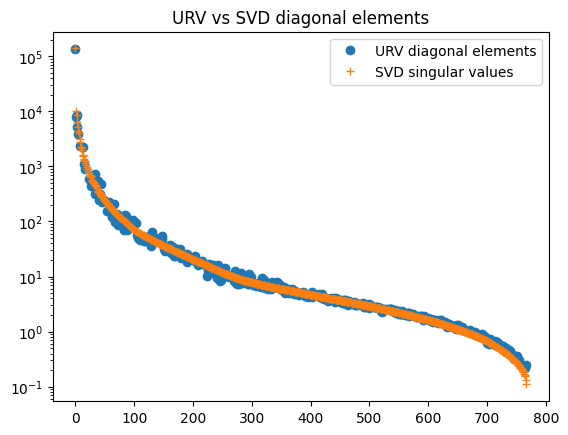

In [9]:
plt.semilogy(ndi,'o',simg,'+')
plt.title('URV vs SVD diagonal elements')
plt.legend(['URV diagonal elements', 'SVD singular values'])
plt.show()

## Comparing PCA performance using different strategies to select the principal directions
In this experiment, we want to compare two different strategies to choose the number of directions used in the compression. We use both tolerance and entropy and a comparison is provided. 

In [10]:
# Since we want to perform the PCA, 
# we subtract the mean from each col
AS = np.copy(np.asarray(imgg))
(nb, na) = AS.shape
meanAS=np.mean(AS,axis=0).reshape(1,na)
As1 = np.copy(np.asarray(imgg))
As1 -=  meanAS # compacted outer product it is the same as using the outer product
print('mean of the columns before subtraction:\n', meanAS) 
print('mean of the columns after subtraction:\n', np.mean(As1,axis=0)) 

mean of the columns before subtraction:
 [[169.64118607 169.57087852 169.49570404 ... 157.78631979 157.82807695
  157.83517682]]
mean of the columns after subtraction:
 [2.85641881e-13 3.26609110e-13 2.92451248e-13 ... 2.13754940e-13
 1.08357767e-13 2.05169215e-13]


In [11]:
U, s, Vh = spl.svd(As1,full_matrices=False)

r*Entropy*perc = [229.51573714] suggested NComp= 229
Correlation index= 0.9999882666825717, 
Error ||Apimg - imgg||/sigma1= 0.0008644612389056554
----------------------------------------------------
r*Entropy*perc = [242.26661142] suggested NComp= 242
Correlation index= 0.9999903480018748, 
Error ||Apimg - imgg||/sigma1= 0.0007840503541828155
----------------------------------------------------
r*Entropy*perc = [252.46731085] suggested NComp= 252
Correlation index= 0.999991588093193, 
Error ||Apimg - imgg||/sigma1= 0.0007319521686592789
----------------------------------------------------
r*Entropy*perc = [253.74239828] suggested NComp= 253
Correlation index= 0.9999916962482635, 
Error ||Apimg - imgg||/sigma1= 0.0007272314721413156
----------------------------------------------------
r*Entropy*perc = [254.76246822] suggested NComp= 254
Correlation index= 0.9999918025838209, 
Error ||Apimg - imgg||/sigma1= 0.0007225601251277877
----------------------------------------------------
r*Entr

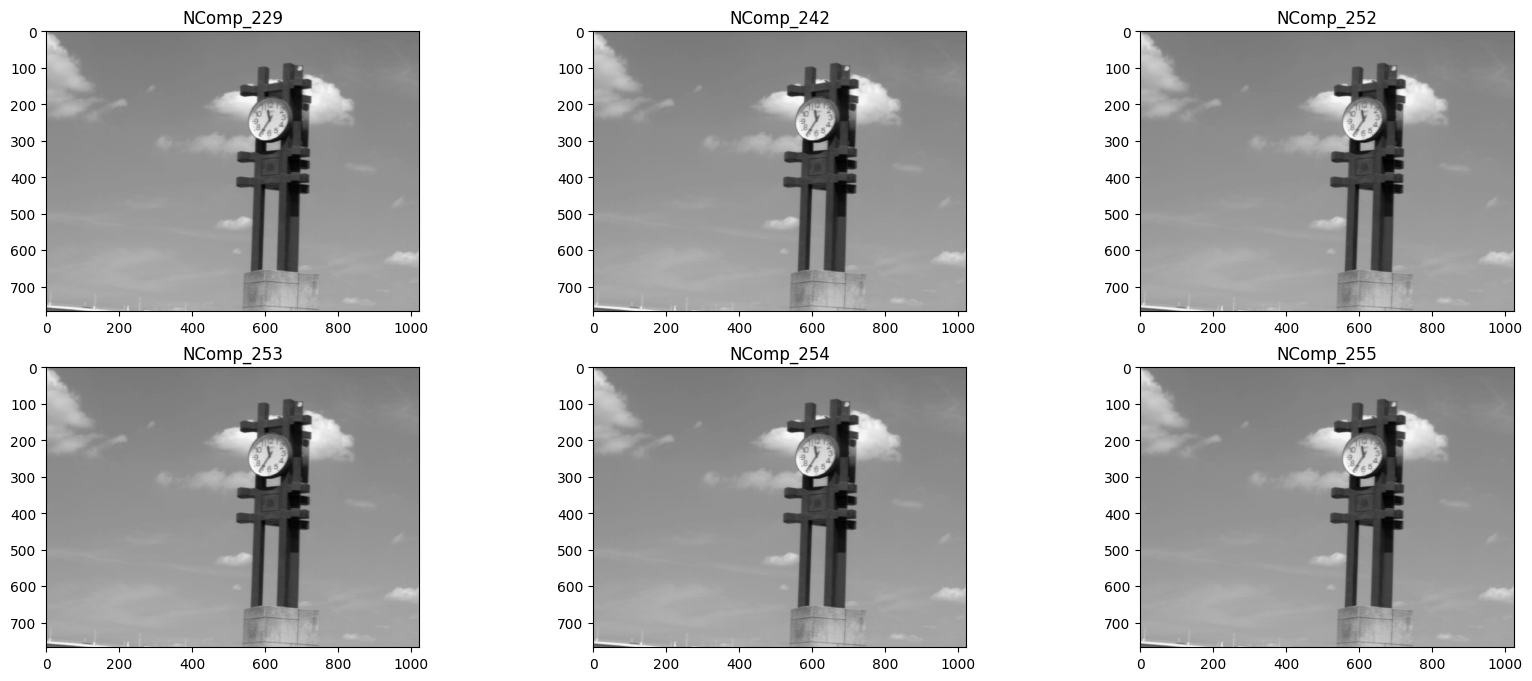

In [12]:
tol=[1e-1,5e-2,1e-2,5e-3,1e-3,0]
i = 0
entropy=True
plt.figure(figsize=(20,8))

for ind in tol:
 if entropy:   
  f=s**2. / np.sum(s**2.) #is based on the eigenvalues of the covariance matrix
  r = simg.shape # number of singular values
  entropy = (-1/np.log(r))*np.sum(f*np.log(f))
  ks = r*entropy
  ks = int(ks[0])
  #print('Entropy =',entropy, 'suggested k=', ks , simg[0:ks],)
  
  perc=1-ind
  nc = r*entropy*perc
  nc = int(nc[0])
  print('r*Entropy*perc =',r*entropy*perc, 'suggested NComp=', nc)
  
  # since we have subtracted the mean, we need to add again 
  # to reconstruct the original image
  Apimg=np.dot(U[:,0:nc]*s[0:nc],Vh[0:nc,:])  + meanAS 
 else:
  f=simg / simg[0] # the approximation properties of the svd
  nc = np.sum(f >= ind)     
  Apimg=np.dot( Uimg[:,0:nc]*simg[0:nc],Vimg[0:nc,:])
  print(f'Tolerance= {tol[i]}, NComp= {nc}')
 
 Apimg=np.dot( Uimg[:,0:nc]*simg[0:nc],Vimg[0:nc,:])
 rhoxy = correlation_index(imgg,Apimg)  
 print(f'Correlation index= {rhoxy}, '
       f'\nError ||Apimg - imgg||/sigma1= {np.linalg.norm(Apimg-imgg)/simg[0]}')
 print('----------------------------------------------------')

 plt.subplot(2, 3, i+1)
 plt.imshow(Apimg, cmap = plt.cm.gray)
 plt.title('NComp_' + str(nc)) 
 i = i+1

## Comparing the computational time required to perform PCA with different svd solver
1) svd_solver = default: compute the SVD for full matrix and compute all the singular values (not good if we need only a few singular values)
2) svd_solver = randomized: very useful when the matrix is large and sparse
3) svd_solver = arpack: used an iterative algorithm that computes few singular values and uses as tool only matrix multiplication. Useful when we would like to compute only few singular values or with sparse and large matrix.

In [13]:
X=np.copy(imgg)
ns = 50

t1=time.process_time()
# we fit the PCA on the matrix X using exactly ns component 
pca = PCA(copy=True,n_components=ns).fit(X)

# then we multiply the vectors of the basis of 
# the range of the matrix times the singular values, 
# which are the principal directions
US = pca.transform(X) 
t2d=time.process_time()-t1
print( "clock default solver = ", t2d )

t1=time.process_time()
pca = PCA(copy=True,n_components=ns,svd_solver='randomized').fit(X)
US = pca.transform(X)
t2d=time.process_time()-t1
print( "clock randomized solver = ", t2d )

t1=time.process_time()
pca = PCA(copy=True,n_components=ns,svd_solver='arpack').fit(X)
US = pca.transform(X)
t2d=time.process_time()-t1
print( "clock arpack solver = ", t2d)

clock default solver =  1.375
clock randomized solver =  2.0625
clock arpack solver =  0.515625
